# Choosing and Training a Model

In this notebook I will try and predict what kind of an incident occured based on where it took place and how long it took to resolve. 

Target: issue_reported(y)
Input vairables: Latitude, Longitude, timespan_min(x)


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.cluster
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, fbeta_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

Import data of clean features

In [2]:
file = 'traffic_feature_engineering.csv'

In [3]:
df = pd.read_csv(file, index_col=False)
df.head()

,published_date,issue_reported,Latitude,Longitude,issue_timespan,geometry,day,hour,month
0,2018-06-13 06:35:59+00:00,Crash Service,30.283797,-97.741906,144.066667,POINT (-97.741906 30.283797),wed,6,jun
1,2018-06-13 10:15:36+00:00,Traffic Hazard,30.339593,-97.700963,64.450000,POINT (-97.700963 30.339593),wed,10,jun
2,2020-04-17 21:25:03+00:00,Crash Service,30.329455,-97.638105,30.000000,POINT (-97.638105 30.329455),fri,21,apr
3,2020-04-17 21:40:52+00:00,Traffic Hazard,30.202806,-97.760701,14.183333,POINT (-97.760701 30.202806),fri,21,apr
4,2020-04-17 21:00:55+00:00,Crash Service,30.184265,-97.687339,149.150000,POINT (-97.68733899999999 30.184265),fri,21,apr


In [4]:
df.describe()

,Latitude,Longitude,issue_timespan,hour
count,244175.000000,244175.000000,244175.000000,244175.000000
mean,30.301787,-97.733279,72.669058,13.656578
std,0.093835,0.087170,90.841620,7.057744
min,30.003883,-98.226709,0.333333,0.000000
25%,30.232014,-97.777104,20.750000,9.000000
50%,30.294387,-97.734336,41.333333,15.000000
75%,30.373832,-97.687295,81.216667,19.000000
max,30.798642,-97.293320,480.000000,23.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244175 entries, 0 to 244174
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   published_date  244175 non-null  object 
 1   issue_reported  244175 non-null  object 
 2   Latitude        244175 non-null  float64
 3   Longitude       244175 non-null  float64
 4   issue_timespan  244175 non-null  float64
 5   geometry        244175 non-null  object 
 6   day             244175 non-null  object 
 7   hour            244175 non-null  int64  
 8   month           244175 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 16.8+ MB


In [6]:
df['issue_reported'].unique()

array(['Crash Service', 'Traffic Hazard', 'VEHICLE FIRE',
       'Injury/Fatality', 'Stalled Vehicle', 'COLLISION',
       'LOOSE LIVESTOCK', 'Traffic Impediment'], dtype=object)

#  Use Label Encoder for categorical data we are trying to predict
Trying to predict the "issue_reported" involves transforming the column using LabelEncoder(). Then a quick check to ensure the numbers line up like before.

In [7]:
le = LabelEncoder()
df['issue_reported']=le.fit_transform(df['issue_reported'])
df.head()

,published_date,issue_reported,Latitude,Longitude,issue_timespan,geometry,day,hour,month
0,2018-06-13 06:35:59+00:00,1,30.283797,-97.741906,144.066667,POINT (-97.741906 30.283797),wed,6,jun
1,2018-06-13 10:15:36+00:00,5,30.339593,-97.700963,64.450000,POINT (-97.700963 30.339593),wed,10,jun
2,2020-04-17 21:25:03+00:00,1,30.329455,-97.638105,30.000000,POINT (-97.638105 30.329455),fri,21,apr
3,2020-04-17 21:40:52+00:00,5,30.202806,-97.760701,14.183333,POINT (-97.760701 30.202806),fri,21,apr
4,2020-04-17 21:00:55+00:00,1,30.184265,-97.687339,149.150000,POINT (-97.68733899999999 30.184265),fri,21,apr


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244175 entries, 0 to 244174
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   published_date  244175 non-null  object 
 1   issue_reported  244175 non-null  int64  
 2   Latitude        244175 non-null  float64
 3   Longitude       244175 non-null  float64
 4   issue_timespan  244175 non-null  float64
 5   geometry        244175 non-null  object 
 6   day             244175 non-null  object 
 7   hour            244175 non-null  int64  
 8   month           244175 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 16.8+ MB


In [9]:
df['issue_reported'].unique()

array([1, 5, 7, 2, 4, 0, 3, 6])

In [10]:
df['issue_reported'].value_counts()

1    93808
5    93012
0    26679
4    11965
2     6016
6     5982
3     5914
7      799
Name: issue_reported, dtype: int64

In [12]:
avg_issue = df.groupby('issue_reported').mean()
avg_issue_span = avg_issue.issue_timespan
avg_issue_span

issue_reported
0     57.598691
1     93.988209
2     86.607976
3     59.923633
4     49.886431
5     55.926763
6    111.492700
7     61.731227
Name: issue_timespan, dtype: float64

In [13]:
median_issue = df.groupby('issue_reported').median()
median_issue_span = median_issue.issue_timespan
median_issue_span

issue_reported
0    37.750000
1    67.000000
2    55.525000
3    34.000000
4    24.716667
5    28.500000
6    46.508333
7    34.583333
Name: issue_timespan, dtype: float64

In [14]:
df['region'].value_counts()

KeyError: 'region'

## Apply LabelEncoder on the new categorical column 'region'.

In [164]:
le2 = LabelEncoder()
df['region']=le2.fit_transform(df['region'])
df.head()

,issue_reported,Latitude,Longitude,day,timespan_min,hour,month,region,lat_from_cntr,lon_from_cntr,dist_from_cntr
0,2,30.283797,-97.741906,2,144.066667,6,6,2,-0.016597,-0.001194,1.849061
1,5,30.339593,-97.700963,2,64.450000,10,6,8,-0.072393,-0.042137,9.009002
2,2,30.329455,-97.638105,4,30.000000,21,4,6,-0.062255,-0.104995,12.228301
3,5,30.202806,-97.760701,4,14.183333,21,4,11,0.064394,0.017601,7.357232
4,2,30.184265,-97.687339,4,149.150000,21,4,10,0.082935,-0.055761,10.665180


### Drop "Latitude" and "Longitude"

In [165]:
df = df.drop(columns=['Latitude', 'Longitude'])
df.head()

,issue_reported,day,timespan_min,hour,month,region,lat_from_cntr,lon_from_cntr,dist_from_cntr
0,2,2,144.066667,6,6,2,-0.016597,-0.001194,1.849061
1,5,2,64.450000,10,6,8,-0.072393,-0.042137,9.009002
2,2,4,30.000000,21,4,6,-0.062255,-0.104995,12.228301
3,5,4,14.183333,21,4,11,0.064394,0.017601,7.357232
4,2,4,149.150000,21,4,10,0.082935,-0.055761,10.665180


## Scaling Timespan and Latitude/Longitude Features
First, create a series variable using .values

In [166]:
series1 = df.timespan_min.values
series2 = df.dist_from_cntr.values
series3 = df.lat_from_cntr.values
series4 = df.lon_from_cntr.values

Then reshape the series to scale it as 2D arrays

In [167]:
series1 = series1.reshape(-1,1)

In [168]:
series2 = series2.reshape(-1,1)

In [169]:
series3 = series3.reshape(-1,1)

In [170]:
series4 = series4.reshape(-1,1)

In [171]:
scaler = StandardScaler()

Then create new columns for for each of the series.

In [172]:
df['scaled_timespan'] = scaler.fit_transform(series1)

In [173]:
df['scaled_dist'] = scaler.fit_transform(series2)

In [174]:
df['scaled_lat_dist'] = scaler.fit_transform(series3)

In [175]:
df['scaled_lon_dist'] = scaler.fit_transform(series4)

In [176]:

df.head()

,issue_reported,day,timespan_min,hour,month,region,lat_from_cntr,lon_from_cntr,dist_from_cntr,scaled_timespan,scaled_dist,scaled_lat_dist,scaled_lon_dist
0,2,2,144.066667,6,6,2,-0.016597,-0.001194,1.849061,2.378811,-1.366489,0.187527,0.099986
1,5,2,64.450000,10,6,8,-0.072393,-0.042137,9.009002,0.372551,-0.392271,-0.405543,-0.367876
2,2,4,30.000000,21,4,6,-0.062255,-0.104995,12.228301,-0.495554,0.045764,-0.297783,-1.086165
3,5,4,14.183333,21,4,11,0.064394,0.017601,7.357232,-0.894118,-0.617019,1.048402,0.314760
4,2,4,149.150000,21,4,10,0.082935,-0.055761,10.665180,2.506905,-0.166922,1.245479,-0.523560


## One Hot Encoding the Categorical Variables

In [177]:
dummies = pd.get_dummies(df, columns=['day','hour','month','region'])

In [178]:
dummies = dummies.drop(columns=['issue_reported', 'timespan_min', 'dist_from_cntr', 'lat_from_cntr', 'lon_from_cntr'])

In [179]:
dummies.head()

,scaled_timespan,scaled_dist,scaled_lat_dist,scaled_lon_dist,day_0,day_1,day_2,day_3,day_4,day_5,...,region_2,region_3,region_4,region_5,region_6,region_7,region_8,region_9,region_10,region_11
0,2.378811,-1.366489,0.187527,0.099986,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0.372551,-0.392271,-0.405543,-0.367876,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,-0.495554,0.045764,-0.297783,-1.086165,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,-0.894118,-0.617019,1.048402,0.314760,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,2.506905,-0.166922,1.245479,-0.523560,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [180]:
X = dummies

In [181]:

y = df.issue_reported

In [182]:
X.shape

(225445, 59)

In [183]:
y.shape

(225445,)

## Train Test Split and Scale

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [185]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Running Default Models and Comparing Algorithms
X and y are set so all models can be fit through these two variables. I will fit three models and see which is most accurate. The four models will be KNN, Random Forest and Decision Tree.

In [186]:
models = []

models.append(('RFC', RandomForestClassifier()))
#models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GradientBoostingClassifier()))


In [187]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=None)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RFC: 0.602409 (0.008281)
NB: 0.596500 (0.007244)


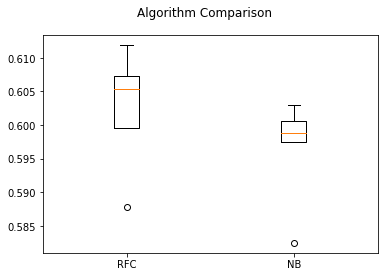

In [188]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Random Forest Accuracy and F1 Scores

In [212]:
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
ba = balanced_accuracy_score(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

print('Random Forest: Balanced Accuracy=%.3f' % (ba))


Random Forest: Accuracy=0.614
Random Forest: f1-score=0.594
Random Forest: Balanced Accuracy=0.349


## Random Forest Hyperparamter Tuning


The Random Forest default performed best. Now to find the best parameters to tune.

In [191]:
forest = RandomForestClassifier()

In [192]:
n_estimators = [120, 300, 500, 800]
max_depth = [5, 8, 15, 25]
min_samples_split = [2, 5, 10, 15]


hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             )

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


In [144]:
print('Best n_estimators:', bestF.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', bestF.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', bestF.best_estimator_.get_params()['min_samples_split'])

Best n_estimators: 500
Best max_depth: 25
Best min_samples_split: 10


In [193]:
forestOpt = RandomForestClassifier(random_state = 1, max_depth = 25, n_estimators = 500, min_samples_split = 10)
                                   
modelOpt = forestOpt.fit(X_train, y_train)
y_pred = modelOpt.predict(X_test)

## Important Variables

In [199]:
class_names=['Crash Service', 'Traffic Hazard', 'COLLISION WITH INJURY',
       'Stalled Vehicle', 'COLLISION', 'LOOSE LIVESTOCK', 'VEHICLE FIRE'] # name  of classes

Confusion matrix, without normalization
[[ 4656    50   363   228     0  2276     0]
 [  982    93   128    49     0   331     0]
 [  147     1 16826     2     3  8621     0]
 [  569     0    28   559     0   484     0]
 [   18     0   863     0     1  2380     0]
 [ 1531     4  6434   181     0 19610     0]
 [  123     8     8     8     0    69     0]]
Normalized confusion matrix
[[6.15e-01 6.60e-03 4.79e-02 3.01e-02 0.00e+00 3.01e-01 0.00e+00]
 [6.20e-01 5.87e-02 8.09e-02 3.10e-02 0.00e+00 2.09e-01 0.00e+00]
 [5.74e-03 3.91e-05 6.57e-01 7.81e-05 1.17e-04 3.37e-01 0.00e+00]
 [3.47e-01 0.00e+00 1.71e-02 3.41e-01 0.00e+00 2.95e-01 0.00e+00]
 [5.52e-03 0.00e+00 2.65e-01 0.00e+00 3.07e-04 7.30e-01 0.00e+00]
 [5.52e-02 1.44e-04 2.32e-01 6.52e-03 0.00e+00 7.06e-01 0.00e+00]
 [5.69e-01 3.70e-02 3.70e-02 3.70e-02 0.00e+00 3.19e-01 0.00e+00]]


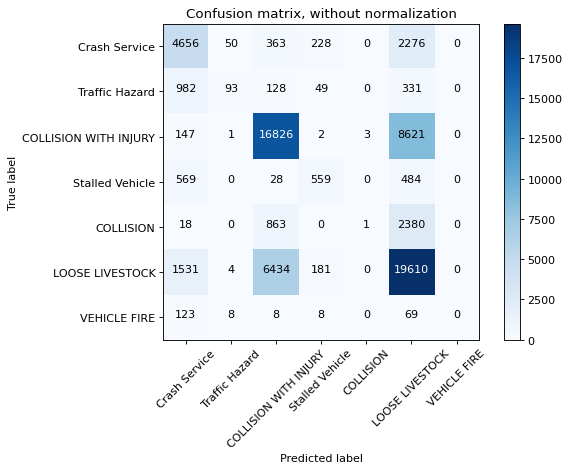

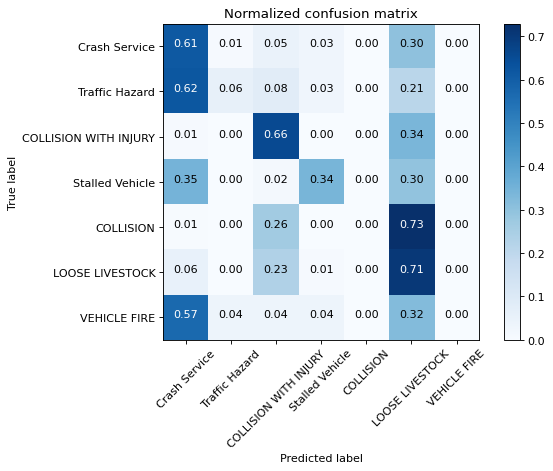

In [205]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6), dpi=80)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6), dpi=80)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

30


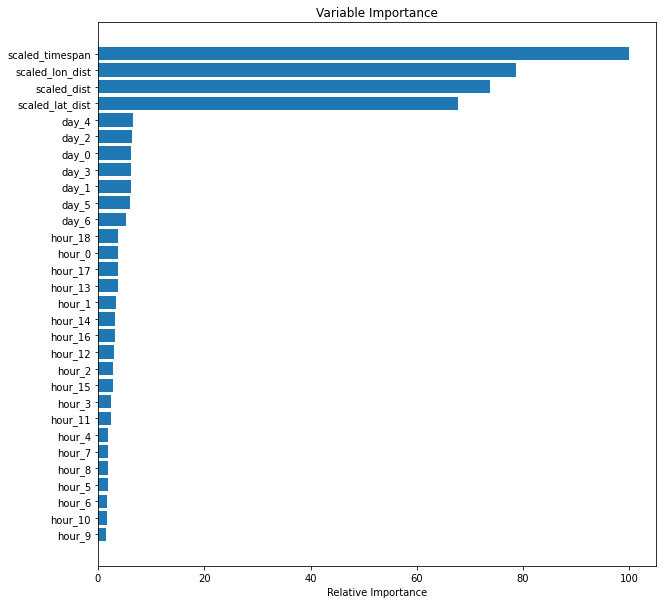

In [208]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Attempting to perform a confusion matrix on Random Forest model

In [209]:
df = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred})
df

,Real Values,Predicted Values
201927,2,2
25560,0,0
27432,5,2
87182,2,2
181100,2,2
...,...,...
198746,0,0
178141,2,2
92719,5,2
129257,2,5


# Running Reports

In [226]:
print('RF Accuracy Score: ', accuracy_score(y_test , y_pred))
print('RF Precision Score: ', precision_score(y_test, y_pred, average='weighted'))
print('RF Recall Score: ', recall_score(y_test, y_pred,  average='weighted'))
print('RF F1 Score: ', f1_score(y_test, y_pred,  average='weighted'))
print('RF F0.5-Measure: ', fbeta_score(y_test, y_pred, beta=0.5,  average='weighted'))
print('RF Confusion Matrix: \n\n', confusion_matrix(y_test , y_pred))
print('RF Classification Report: \n\n', classification_report(y_test, y_pred))

RF Accuracy Score:  0.6141585593044918
RF Precision Score:  0.5985253459645457
RF Recall Score:  0.6141585593044918
RF F1 Score:  0.59359501717355
RF F0.5-Measure:  0.585513772368874
RF Confusion Matrix: 

 [[ 4754    88   399   263     2  2067     0]
 [  985   105   129    52     0   312     0]
 [  212    15 17363     3    45  7962     0]
 [  555     3    25   618     0   439     0]
 [   25     1  1036     0    46  2154     0]
 [ 1635    21  7192   205    57 18650     0]
 [  119    10     6     9     0    70     2]]


NameError: name 'classification_report' is not defined

## For some reason all my scores are the same: 0.6155048903280179

## Dropping low performing variables?????????/

In [138]:
X = df[['scaled_lon_dist','scaled_lon_dist']]

In [139]:
y = df.issue_reported

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [141]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)